In [1]:
#|hide
#|eval: false
! [ -e /content ] && pip install -Uqq fastrl['dev'] pyvirtualdisplay && \
                     apt-get install -y xvfb python-opengl > /dev/null 2>&1 
# NOTE: IF YOU SEE VERSION ERRORS, IT IS SAFE TO IGNORE THEM. COLAB IS BEHIND IN SOME OF THE PACKAGE VERSIONS

In [2]:
#|hide
#|eval: false
from fastcore.imports import in_colab
# Since colab still requires tornado<6, we don't want to import nbdev if we don't have to
if not in_colab():
    from nbdev.showdoc import *
    from nbdev.imports import *
    if not os.environ.get("IN_TEST", None):
        assert IN_NOTEBOOK
        assert not IN_COLAB
        assert IN_IPYTHON
else:
    # Virutual display is needed for colab
    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(400, 300))
    display.start()

In [3]:
#|default_exp agents.dqn.double

In [4]:
#|export
# Python native modules
import os
from collections import deque
# Third party libs
from fastcore.all import *
import torchdata.datapipes as dp
from torch.utils.data.dataloader_experimental import DataLoader2
from torch.utils.data.datapipes._typing import _DataPipeMeta, _IterDataPipeMeta
from torchdata.dataloader2.graph import find_dps,traverse,DataPipe,replace_dp,remove_dp
# Local modules
import torch
from torch.nn import *
import torch.nn.functional as F
from torch.optim import *
from fastai.torch_basics import *
from fastai.torch_core import *

from fastrl.core import *
from fastrl.agents.core import *
from fastrl.pipes.core import *
from fastrl.data.block import *
from fastrl.memory.experience_replay import *
from fastrl.agents.core import *
from fastrl.agents.discrete import *
from fastrl.loggers.core import *
from fastrl.loggers.jupyter_visualizers import *
from fastrl.learner.core import *
from fastrl.agents.dqn.basic import *
from fastrl.agents.dqn.target import *

# DQN Double
> Instead of using the actions from memory to train on, use the actions chosen by the current model.



## Training DataPipes

In [5]:
#|export
class DoubleQCalc(dp.iter.IterDataPipe):
    def __init__(self,source_datapipe=None):
        self.source_datapipe = source_datapipe
        if source_datapipe is not None: self.learner = find_dp(traverse(self),LearnerBase)
                
    def __iter__(self):
        for batch in self.source_datapipe:
            self.learner.done_mask = batch.terminated.reshape(-1,)
            with torch.no_grad():
                chosen_actions = self.learner.model(batch.next_state).argmax(dim=1).reshape(-1,1)
                self.learner.next_q = self.learner.target_model(batch.next_state).gather(1,chosen_actions)
            self.learner.next_q[self.learner.done_mask] = 0
            yield batch
            
    @classmethod
    def replace_dp(cls,old_dp=(QCalc,TargetModelQCalc)) -> Callable[[DataPipe],DataPipe]:
        def _replace_dp(pipe):
            found = False
            for _old_dp in old_dp:
                try:
                    old_dp_instance = find_dp(traverse(pipe),_old_dp)
                    v = replace_dp(
                        traverse(pipe),
                        old_dp_instance,
                        cls(old_dp_instance.source_datapipe)
                    )
                    pipe = list(v.values())[0][0]
                    found = True
                except LookupError: pass
            if not found: 
                warn(f'Unable to find: {old_dp} in {cls} given {traverse(pipe)}')
            return pipe
        return _replace_dp

Try training with basic defaults...

In [6]:
from fastrl.envs.gym import *
from fastrl.loggers.vscode_visualizers import *

In [7]:
# Setup Loggers
logger_base = ProgressBarLogger(epoch_on_pipe=EpocherCollector,
                 batch_on_pipe=BatchCollector)

# Setup up the core NN
torch.manual_seed(0)
model = DQN(4,2)
# Setup the Agent
agent = DQNAgent(model,[logger_base],max_steps=4000)
# Setup the DataBlock
block = DataBlock(
    GymTransformBlock(agent=agent,nsteps=1,nskips=1,firstlast=False,n=1000,bs=1)
)
dls = L(block.dataloaders(['CartPole-v1']*1))
# Setup the Learner
learner = DQNLearner(model,dls,logger_bases=[logger_base],bs=128,max_sz=100_000,
                    dp_augmentation_fns=[
                        TargetModelUpdater.insert_dp(),
                        DoubleQCalc.replace_dp()
                    ])
learner.fit(3)
# learner.fit(25)

loss,episode,rolling_reward,epoch,batch,epsilon
0.02679533,47,21.565217,1,1000,0.749500
0.027366517,76,25.800000,2,1000,0.499250
0.1599923,99,29.224490,2,1000,0.249250


The DQN learners, but I wonder if we can get it to learn faster...

In [8]:
# Setup Loggers
logger_base = ProgressBarLogger(epoch_on_pipe=EpocherCollector,
                 batch_on_pipe=BatchCollector)

# Setup up the core NN
torch.manual_seed(0)
model = DQN(4,2)
# Setup the Agent
agent = DQNAgent(model,[logger_base],max_steps=10000)
# Setup the DataBlock
block = DataBlock(
    GymTransformBlock(agent=agent,nsteps=2,nskips=2,firstlast=True,n=1000,bs=1), # We basically merge 2 steps into 1 and skip. 
    (GymTransformBlock(agent=agent,nsteps=2,nskips=2,firstlast=True,n=100,include_images=True),VSCodeTransformBlock())
)
# pipes = L(block.datapipes(['CartPole-v1']*1,n=10))
dls = L(block.dataloaders(['CartPole-v1']*1))
# Setup the Learner
learner = DQNLearner(model,dls,logger_bases=[logger_base],bs=128,max_sz=20_000,nsteps=2,lr=0.001,
                    dp_augmentation_fns=[
                        TargetModelUpdater.insert_dp(),
                        DoubleQCalc.replace_dp()
                    ])
learner.fit(3)
# learner.fit(10)

loss,episode,rolling_reward,epoch,batch,epsilon
0.12799351,86,23.600000,1,1000,0.812100
0.8877113,129,43.060000,2,1000,0.618200
2.014233,149,68.900000,2,1000,0.421100


/opt/conda/lib/python3.7/site-packages/gym/core.py:52: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecated; "


Creating gif from 100 frames


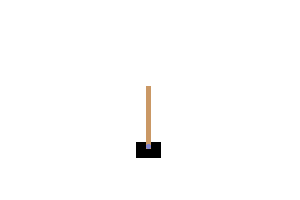

In [14]:
learner.validate()

In [15]:
#|hide
#|eval: false
from fastcore.imports import in_colab

# Since colab still requires tornado<6, we don't want to import nbdev if we don't have to
if not in_colab():
    from nbdev import nbdev_export
    nbdev_export()

/opt/conda/lib/python3.7/site-packages/astroid/node_classes.py:96: DeprecationWarning: The 'astroid.node_classes' module is deprecated and will be replaced by 'astroid.nodes' in astroid 3.0.0
  DeprecationWarning,
